# Installation

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
!pip install bnlp_toolkit




INFO: pip is looking at multiple versions of bnlp-toolkit to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 5.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.4/175.4 kB 14.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.4/54.4 kB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 26.5/26.5 MB 61.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.4/34.4 MB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 55.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.4/78.4 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 51.8 MB/s eta 0:00:00
  Created wheel for emoji: filename=emoji-1.7.0-py3-none-any.whl size=171031 sha256=ecf5f4df749dd71

## Import Necessery Libraries

In [ ]:
 #importing all necessari libraries . For tokenization we will use bnlp tokenizer and create our own embedder
from bnlp import NLTKTokenizer
import string
from bnlp import CleanText
import re
import random
from itertools import chain
from gensim.models import Word2Vec
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import matplotlib.font_manager as fm

import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Input, Embedding, Conv1D, MaxPooling1D, Flatten, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.utils import compute_class_weight
from sklearn.utils import class_weight
from keras.callbacks import EarlyStopping
from tensorflow.keras.regularizers import l2

import numpy as np
from tensorflow.keras.layers import Input, Embedding, LSTM, Bidirectional, GlobalAveragePooling1D, Dense
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import load_model

import pickle



punkt not found. downloading...


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Reading Dataset,Preprocessing ,Creating vocabulary and Embedder

**Next two cells are for defined some necessary Functions**

In [ ]:
# To reduce our dataset size we only have used some portion of our dataset
# This function help us to get specified percentage of portion(mainly lines) of our wiki dataset.
def select_percentage_of_lines(lines, percentage):

    total_lines = len(lines)
    num_lines_to_select = int((percentage / 100) * total_lines)
    selected_lines = lines[:num_lines_to_select]
    return selected_lines


# This function is to read our text file .
def read_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.read()
    return text

# As same of read_file function . only modification is by this function , we return only a specified percentage of data using selecet_percentage_of_lines function.
def read_large_file(file_path):
    with open(file_path, 'r', encoding='utf-8') as file:
        text = file.readlines()
        text = select_percentage_of_lines(text,20)
        #rint(text)
    return text

# This function is used to separate complete sentence using sentence ending puntuaion mark(Bangla)
def separate_sentences(text):
    # Define the sentence-ending punctuation marks
    sentence_endings = ['?', '!', '।',';']

    sentences = []
    current_sentence = []

    for char in text:
        current_sentence.append(char)
        if char in sentence_endings:
            sentences.append(''.join(current_sentence).strip())
            current_sentence = []

    # Add any remaining text as the last sentence
    if current_sentence:
        sentences.append(''.join(current_sentence).strip())

    return sentences

# This function is for removing english words or chars from our dataset .
def remove_english_words(text):

    return re.sub(r'\b[a-zA-Z]+\b', '', text)


# This is focused to delete parentheses and words inside parentheses
def remove_parentheses_and_text(lines):
    cleaned_lines = [re.sub(r'\([^)]*\)', '', line) for line in lines]
    return cleaned_lines



In [ ]:
# Initialize NLTK Tokenizer
tokenizer = NLTKTokenizer()

# Using BNLP built-in Text cleaning function to clean our text data .
clean_text = CleanText(
   fix_unicode=True,
   unicode_norm=True,
   unicode_norm_form="NFKC",
   remove_url=False,
   remove_email=True,
   remove_emoji=True,
   remove_number=True,
   remove_digits=True,
   remove_punct=True,
   replace_with_url="<URL>",
   replace_with_email="<EMAIL>",
   replace_with_number="<NUMBER>",
   replace_with_digit="<DIGIT>",
   replace_with_punct = ""
)

# This function is for removing hyphens
def remove_hyphens(text):
    # Remove hyphens from the text
    cleaned_text = text.replace('\u002D', '')
    return cleaned_text

# This function is used to remove unwanted chars like dashes and different unwanted character
def remove_unwanted_char(text):
  cleaned_text = text.replace('—','')
  cleaned_text = cleaned_text.replace('<','')
  cleaned_text = cleaned_text.replace('>','')
  cleaned_text = cleaned_text.replace('/','')
  cleaned_text = cleaned_text.replace('...','')

  return cleaned_text


# This function makes sure only the bangla characters will be present in our dataset

def is_bangla(text):
    bangla_pattern = re.compile(r'^[\u0980-\u09FF\s]+$')
    return bool(bangla_pattern.match(text))

**Reading Datasets**

In [ ]:
# Reading and Joining our text files used as dataset
# Ignore variable name and replace your dataset paths
# Used two functions for reading file . For large files, we have used read_large_file to get a specified percentag line from the large file to reduce dataset size
# we have used Azad bhai's(Famous Bengali poet and writer now a days) facebook status, News from daily songbad , wikipedia dataset and some self-written bangla lines as test

azad_texts = read_file('/content/drive/MyDrive/azad_bhai.txt')
songbad_texts = read_file('/content/drive/MyDrive/scraped_bengali_text.txt')
wiki = read_large_file('/content/drive/MyDrive/content_texts.txt')
wiki = ''.join(wiki)
test = read_file('/content/drive/MyDrive/test.txt')


# Combine all the different sources data to make dataset
alltexts = azad_texts + '\n' + songbad_texts + '\n' + wiki + '\n' + test
alltexts = remove_english_words(alltexts)

In [ ]:
# Separatig complete sentences as we will continue our work based on lines
# Texts of dataset will be splited as lines

sp_texts = separate_sentences(alltexts)
len(sp_texts)

1627932

In [ ]:
# Removing parenthes and texts inside parenthese
sp_texts = remove_parentheses_and_text(sp_texts)
len(sp_texts)

357438

In [ ]:
# Cleaning each line of our dataset and put all lines in a list call texts
texts = []

for line in sp_texts:
  temp = clean_text(line)
  temp = remove_hyphens(temp)
  temp = remove_unwanted_char(temp)
  texts.append(temp)


texts = [text.replace('\n', ' ') for text in texts]


In [ ]:
len(texts)

357438

In [ ]:
# Ensure only bengali char will be presented in our dataset by predifiened funciton
texts = [text for text in texts if is_bangla(text)]
len(texts)

288415

In [ ]:
# Removing 0 lengths lines if present in our dataset
texts = [text for text in texts if len(text)!=0]
len(texts)

288415

In [ ]:
# Tokenize our dataset
# Put all the tokens (here words) in a list
tokenized_text = []

for text in texts:
  token = tokenizer.word_tokenize(text)
  tokenized_text.append(token)


In [ ]:
# Save our Cleaned dataset as a text file for further use
file_name = "saved_list.txt"

# Open the file in write mode ('w')
with open(file_name, "w") as file:
    # Write each item in the list to the file, one per line
    for item in texts:
        file.write(item + "\n")

In [ ]:
# Creating a vocabulary called word_index
# This vocabulary will be used our project throughout
# Every word will have a index number and indexing will be started from 1


# Flatten the list of lists
flattened_tokens = list(chain.from_iterable(tokenized_text))

# Create the word_index dictionary
word_index = {word: index for index, word in enumerate(set(flattened_tokens), start=1)}

In [ ]:
len(word_index)

133351

In [ ]:
# Save our vocabulary to use further in our project
# This will save our time in case we need again our vocabulary afer current session

with open('word_index.pkl', 'wb') as pickle_file:
    pickle.dump(word_index, pickle_file)

In [ ]:
# Train and Save our embedder .
# This embedder will be used throughout our project


# Define and train Word2Vec model
model = Word2Vec(sentences=tokenized_text, vector_size=100, window=5, min_count=1, workers=5, sg=0, epochs=100)

# Save the trained model
model.save('word2vec_com_cbow_.bin')

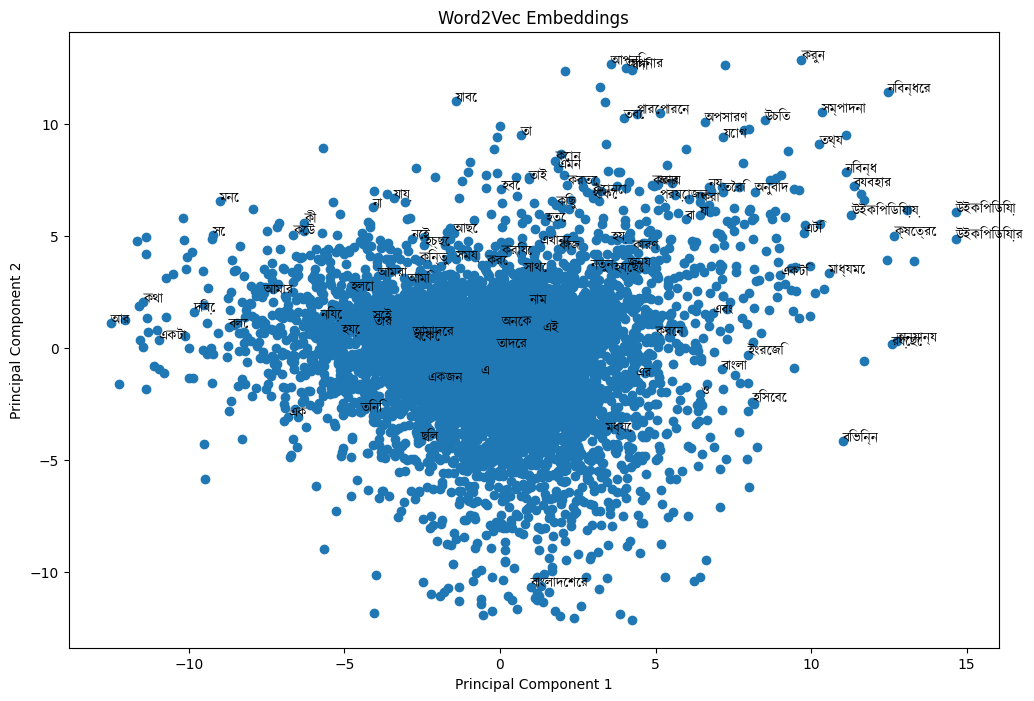

Vocabulary: ['না', 'করে', 'করা', 'এবং', 'এই', 'ও', 'হয়', 'জন্য', 'করতে', 'বা', 'একটি', 'আমি', 'থেকে', 'হবে', 'যে', 'কোনো', 'বাংলা', 'তার', 'কিন্তু', 'নিবন্ধ', 'হয়েছে', 'করার', 'সাথে', 'আপনার', 'নয়', 'নিয়ে', 'এর', 'আপনি', 'ব্যবহার', 'কোন', 'কিছু', 'পারে', 'তবে', 'যায়', 'মনে', 'যদি', 'আছে', 'হয়ে', 'করুন', 'তা', 'আমার', 'আর', 'এটি', 'উচিত', 'পারেন', 'সেই', 'তিনি', 'হতে', 'তৈরি', 'বলে', 'ছিল', 'নিবন্ধের', 'যা', 'করেন', 'উইকিপিডিয়া', 'তাই', 'সম্পাদনা', 'থাকে', 'উইকিপিডিয়ায়', 'কথা', 'সময়', 'উইকিপিডিয়ার', 'নেই', 'সে', 'নাম', 'রয়েছে', 'বিভিন্ন', 'মধ্যে', 'তাদের', 'কাজ', 'হিসেবে', 'এক', 'দিয়ে', 'এ', 'অপসারণ', 'আমরা', 'হচ্ছে', 'আমাদের', 'একটা', 'করি', 'কী', 'এমন', 'তথ্য', 'ইংরেজি', 'একজন', 'অনুবাদ', 'মাধ্যমে', 'ক্ষেত্রে', 'কেউ', 'কারণ', 'অন্য', 'বাংলাদেশের', 'যাবে', 'এখানে', 'যোগ', 'অন্যান্য', 'প্রয়োজন', 'নতুন', 'অনেক', 'হলো', 'দেওয়া', 'আলোচনা', 'আপনাকে', 'আগে', 'করছি', 'শুরু', 'অবদান', 'সম্পর্কে', 'পাতায়', 'উপর', 'পর', 'নিবন্ধটি', 'প্রধান', 'এখন', 'নিজের', 'যেতে', 'তারা', 'হলে',

In [ ]:
# visualize our words graph
vocab = list(model.wv.index_to_key)
vectors = model.wv[vocab]

# Reduce the dimensionality using PCA for plotting
pca = PCA(n_components=2)
result = pca.fit_transform(vectors)

# Plot the Word2Vec embeddings
plt.figure(figsize=(12, 8))
plt.scatter(result[:, 0], result[:, 1])
plt.rcParams['font.family'] =  'DejaVu Sans'
# Annotate each point with the corresponding word
prop = fm.FontProperties(fname='kalpurush.ttf')
for i, word in enumerate(vocab[:100]):
    plt.annotate(word, xy=(result[i, 0], result[i, 1]),fontproperties=prop)

plt.title('Word2Vec Embeddings')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.show()

# Display the vocabulary
print("Vocabulary:", vocab)

In [ ]:
# Finding our similar words
# To Check accuracy of our embedder

def find_similar_words(word, topn=5):
    similar_words = model.wv.similar_by_word(word, topn=topn)
    return similar_words

In [ ]:
similar = find_similar_words('করা', topn=10)
similar


[('করাও', 0.7072429656982422),
 ('করতে', 0.669126033782959),
 ('করে', 0.652880072593689),
 ('করবে', 0.6501822471618652),
 ('করেছে', 0.6454281806945801),
 ('করার', 0.637057900428772),
 ('করলে', 0.6351326107978821),
 ('করাই', 0.6323143243789673),
 ('করলেও', 0.6247053146362305),
 ('করাটা', 0.6243581771850586)]

**Call your Saved Vocabulary and Dataset (If you have otherwise skip this section)**

In [ ]:


# Specify the path to your pickle file
file_path = "/content/drive/MyDrive/word_index.pkl"

# Open the pickle file in read-binary mode
with open(file_path, "rb") as file:
    # Load the content of the pickle file into a variable
    word_index = pickle.load(file)



In [ ]:
#load previous clean text and make list
# Specify the path to your text file
file_path = "/content/drive/MyDrive/saved_list.txt"

# Read the file and create a list where each line is an item
with open(file_path, "r") as file:
    lines_list = file.read().splitlines()



In [ ]:
len(lines_list)

1230279

In [ ]:
# As our saved dataset is larger for our machine .
# We slice our saved dataset and train our model .
texts = lines_list[1050000:]
len(texts)

180279

# Dataset Preparation to Train our Models


In [ ]:
def replace_tokens_with_indices(tokens, word_index):
    """
    Replaces a list of tokens with their corresponding indices from the word_index dictionary.

    Args:
        tokens (list of str): List of tokens to replace.
        word_index (dict): Dictionary mapping words to their corresponding tokens.

    Returns:
        list of int: List of indices corresponding to the tokens.
    """
    indices = []
    for token in tokens:
        index = word_index.get(token, 0)  # Use 0 (or another index) for unknown tokens
        #index = int(index)
        if index == 309363:
          continue
        indices.append(index)
    return indices

In [ ]:
# This fuction is to generate sub sequence of complete sentence to make incomplete sentence
# Labelize our data
# Complete lines as 1 and inccomplete lines as 0

input_ids = []
attention_masks = []
labels = []

# Function to generate sub-sequences and labels
def generate_subsequences_and_labels(text,word_index):
    tokens = tokenizer.word_tokenize(text)
    input_id = replace_tokens_with_indices(tokens, word_index)
    subsequences = []
    subsequence_labels = []

    for i in range(1, len(tokens) + 1):

        subsequences.append(input_id[:i])
        if i == len(tokens):

            subsequence_labels.append(1)
        else:
            subsequence_labels.append(0)

    return subsequences, subsequence_labels






In [ ]:
# This is all the same of previous function just have a little modification
# This will select only a specified percentage of sub-sequences (Incomplete sentences) as incomplete sentece will be significantly larger than complete one




def generate_subsequences_and_labels(text, word_index, remove_percentage=0.80):
    tokens = tokenizer.word_tokenize(text)
    input_id = replace_tokens_with_indices(tokens, word_index)
    subsequences = []
    subsequence_labels = []

    for i in range(1, len(tokens) + 1):
        subsequences.append(input_id[:i])
        if i == len(tokens):
            subsequence_labels.append(1)
        else:
            subsequence_labels.append(0)

    # Identify the indices of subsequences with length 1 or 2 and label 0
    short_negative_indices = [i for i, (seq, label) in enumerate(zip(subsequences, subsequence_labels)) if label == 0]

    # Determine how many to remove based on the remove_percentage
    num_to_remove = int(remove_percentage * len(short_negative_indices))
    indices_to_remove = random.sample(short_negative_indices, num_to_remove)

    # Remove the selected indices
    subsequences = [seq for i, seq in enumerate(subsequences) if i not in indices_to_remove]
    subsequence_labels = [label for i, label in enumerate(subsequence_labels) if i not in indices_to_remove]

    return subsequences, subsequence_labels


In [ ]:
# Prepare the data
# Separate lines and labels namely as X and y


input_ids = []
attention_masks = []
labels = []

for text in texts:
    if text.strip():
      subsequences, subsequence_labels = generate_subsequences_and_labels(text.strip(),word_index)
      input_ids.extend(subsequences)
      #attention_masks.extend([[1] * len(seq) for seq in subsequences])
      labels.extend(subsequence_labels)

# Pad sequences
max_len = max(len(seq) for seq in input_ids)
#max_len = 483
input_ids = tf.keras.preprocessing.sequence.pad_sequences(input_ids, maxlen=max_len, padding='post')
#attention_masks = tf.keras.preprocessing.sequence.pad_sequences(attention_masks, maxlen=max_len, padding='post')
labels = np.array(labels,dtype=np.float32)
#labels = labels.reshape(-1, 1)


# Convert to TensorFlow dataset
#dataset = tf.data.Dataset.from_tensor_slices((input_ids, attention_masks, labels))

In [ ]:
input_ids.shape

(640061, 483)

In [ ]:
# create a dataframe with our lines and labels

data = {
    'input_ids': [' '.join(map(str, seq)) for seq in input_ids],
    'label': labels.flatten()
}

df = pd.DataFrame(data)

In [ ]:
df.to_csv('sentence_boundary_data.csv')

In [ ]:
# Checking label count
df['label'].value_counts()

,count
label,
0.0,460263
1.0,179798


In [ ]:
# Calculate the number of rows to drop
# Drop again  some incomplete sentence to make a balanced dataset

num_to_drop = int(0.65 * len(df[df['label'] == 0]))
num_to_drop


299170

In [ ]:
# Randomly sample the rows to drop
rows_to_drop = df[df['label'] == 0].sample(n=num_to_drop).index

# Drop the sampled rows
df_dropped = df.drop(rows_to_drop)

In [ ]:
# Again check the label counts
df_dropped['label'].value_counts()

,count
label,
1.0,179798
0.0,161093


In [ ]:
# Converting dropped dataframe as numpy array

input_ids = np.array(df_dropped['input_ids'])
labels = np.array(df_dropped['label'],dtype = np.float32)

In [ ]:
# Parsing numpy array and convert to avoid any incompitabe error
parsed_data = [list(map(int, item.split())) for item in input_ids]

# Convert the list of lists into a numpy array
inp_ids = np.array(parsed_data)

In [ ]:
inp_ids

array([[  120, 14787,  9587, ...,     0,     0,     0],
       [  120, 14787,  9587, ...,     0,     0,     0],
       [  120, 14787,  9587, ...,     0,     0,     0],
       ...,
       [21135, 15714, 29347, ...,     0,     0,     0],
       [21135, 15714, 29347, ...,     0,     0,     0],
       [21135, 15714, 29347, ...,     0,     0,     0]])

# Train Our Models

In [ ]:
# Load our pretrained(built and trained on our data) Embedder
word2vec_model = Word2Vec.load("/content/drive/MyDrive/word2vec_com_cbow_.bin")

embedding_layer_weights = word2vec_model.wv.vectors
print(embedding_layer_weights.shape)

(309363, 100)


**Re-train our pretrained model(Only if we have a pretrained model. Otherwise skip)**

In [ ]:

# Load the pre-trained model
model = load_model('/content/drive/MyDrive/enc_model_five.h5')



class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(labels),
                                                  y=labels)
class_weights = dict(enumerate(class_weights))


# Train the model
batch_size = 128
epochs = 30

model.compile(optimizer=Adam(0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Save the model


early_stopping = EarlyStopping(monitor='val_loss', patience=5,restore_best_weights = True)


history =model.fit(inp_ids, labels, batch_size=batch_size, epochs=epochs, validation_split=0.20,class_weight = class_weights,callbacks=[early_stopping])
model.save('enc_model_six.h5')


Epoch 1/30
2131/2131 ━━━━━━━━━━━━━━━━━━━━ 212s 96ms/step - accuracy: 0.8812 - loss: 0.2922 - val_accuracy: 0.8742 - val_loss: 0.3065
Epoch 2/30
2131/2131 ━━━━━━━━━━━━━━━━━━━━ 206s 97ms/step - accuracy: 0.8909 - loss: 0.2746 - val_accuracy: 0.8739 - val_loss: 0.3072
Epoch 3/30
2131/2131 ━━━━━━━━━━━━━━━━━━━━ 262s 97ms/step - accuracy: 0.8979 - loss: 0.2596 - val_accuracy: 0.8706 - val_loss: 0.3118
Epoch 4/30
2131/2131 ━━━━━━━━━━━━━━━━━━━━ 262s 97ms/step - accuracy: 0.9056 - loss: 0.2438 - val_accuracy: 0.8717 - val_loss: 0.3201
Epoch 5/30
2131/2131 ━━━━━━━━━━━━━━━━━━━━ 261s 97ms/step - accuracy: 0.9111 - loss: 0.2328 - val_accuracy: 0.8734 - val_loss: 0.3153
Epoch 6/30
2131/2131 ━━━━━━━━━━━━━━━━━━━━ 262s 97ms/step - accuracy: 0.9179 - loss: 0.2198 - val_accuracy: 0.8718 - val_loss: 0.3230


**Build and Train Our CNN Based Model**

In [ ]:


max_len = max_len
vocab_size = len(word_index)

# Constants
embedding_dim = 100

# Define the CNN model
input_layer = Input(shape=(max_len,), name='input_layer')
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len,weights=[embedding_layer_weights])(input_layer)

conv_layer = Conv1D(filters=128, kernel_size=10, activation='relu',kernel_regularizer=l2(0.00001))(embedding_layer)
pooling_layer = MaxPooling1D(pool_size=2)(conv_layer)
flatten_layer = Flatten()(pooling_layer)
dropout_layer = Dropout(0.5)(flatten_layer)

output_layer = Dense(1, activation='sigmoid')(dropout_layer)

model = Model(inputs=input_layer, outputs=output_layer)

# Compile the model
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
loss = tf.keras.losses.BinaryCrossentropy()
metrics = ['accuracy']
model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(labels),
                                                  y=labels)
class_weights = dict(enumerate(class_weights))


# Train the model
batch_size = 128
epochs = 30



# Save the model


early_stopping = EarlyStopping(monitor='val_loss', patience=3,restore_best_weights = True)


history =model.fit(inp_ids, labels, batch_size=batch_size, epochs=epochs, validation_split=0.20,class_weight = class_weights,callbacks=[early_stopping])
model.save('cnn_model.h5')


Epoch 1/30
3576/3576 ━━━━━━━━━━━━━━━━━━━━ 87s 23ms/step - accuracy: 0.6533 - loss: 0.6252 - val_accuracy: 0.7353 - val_loss: 0.5369
Epoch 2/30
3576/3576 ━━━━━━━━━━━━━━━━━━━━ 132s 21ms/step - accuracy: 0.7408 - loss: 0.5247 - val_accuracy: 0.7941 - val_loss: 0.4519
Epoch 3/30
3576/3576 ━━━━━━━━━━━━━━━━━━━━ 85s 22ms/step - accuracy: 0.7934 - loss: 0.4515 - val_accuracy: 0.8168 - val_loss: 0.4105
Epoch 4/30
3576/3576 ━━━━━━━━━━━━━━━━━━━━ 79s 21ms/step - accuracy: 0.8207 - loss: 0.4073 - val_accuracy: 0.8338 - val_loss: 0.3842
Epoch 5/30
3576/3576 ━━━━━━━━━━━━━━━━━━━━ 82s 22ms/step - accuracy: 0.8378 - loss: 0.3779 - val_accuracy: 0.8456 - val_loss: 0.3710
Epoch 6/30
3576/3576 ━━━━━━━━━━━━━━━━━━━━ 82s 22ms/step - accuracy: 0.8497 - loss: 0.3575 - val_accuracy: 0.8510 - val_loss: 0.3557
Epoch 7/30
3576/3576 ━━━━━━━━━━━━━━━━━━━━ 84s 22ms/step - accuracy: 0.8590 - loss: 0.3423 - val_accuracy: 0.8562 - val_loss: 0.3522
Epoch 8/30
3576/3576 ━━━━━━━━━━━━━━━━━━━━ 82s 22ms/step - accuracy: 0.8660 

In [ ]:
# Testing Model performance with a single line

input_text = 'তারপর বিকেল বেলা অফিস থেকে বাসায় ফিরলাম'
max_len = 483

print(input_text)
tkns = tokenizer.word_tokenize(input_text)
print(tkns)
nm_tkns = replace_tokens_with_indices(tkns,word_index)
print(nm_tkns)
inp =  tf.keras.preprocessing.sequence.pad_sequences([nm_tkns], maxlen=max_len, padding='post')

#print(inp)
print(input_text)
pred = model.predict(inp)

print(pred)

if pred > 0.5:
  print('Sentence status complete.')
else:
  print('sentence status incomplete.')


তারপর বিকেল বেলা অফিস থেকে বাসায় ফিরলাম
['তারপর', 'বিকেল', 'বেলা', 'অফিস', 'থেকে', 'বাসায়', 'ফিরলাম']
[286224, 175423, 109624, 130138, 260716, 41820, 146095]
তারপর বিকেল বেলা অফিস থেকে বাসায় ফিরলাম
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
[[0.7730922]]
Sentence status complete.


In [ ]:
# Models performance plotting fuinction

def plot_training_accuracy(history, savePlot=False, title = "fig"):
    plt.plot(history['loss'])
    plt.plot(history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train loss', 'validation loss'], loc='upper left')
    if savePlot:
        plt.savefig(title+'_loss.png')
    plt.show()

    plt.plot(history['accuracy'])
    plt.plot(history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'validation'], loc='upper left')

    if savePlot:
        plt.savefig(title+'_acc.png')
    plt.show()

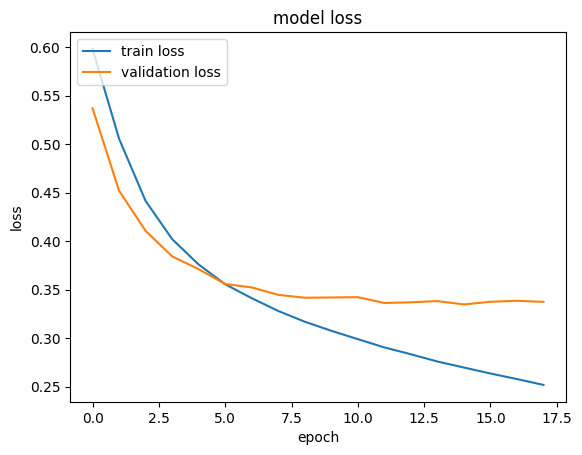

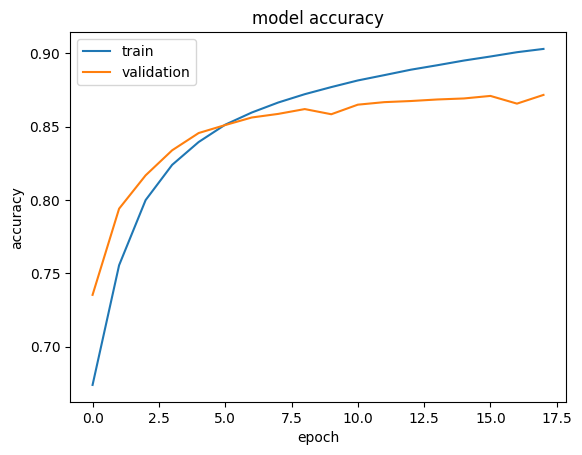

In [ ]:
# checking cnn models performance graph
plot_training_accuracy(history.history, savePlot=False, title = "fig")


**Build and Train our LSTM based Model**

In [ ]:



# Hyperparameters
vocab_size = len(word_index)  # +1 for padding token
embedding_dim = 100
hidden_size = 128
output_size = 1  # Binary classification


# Define the encoder model
input_seq = Input(shape=(max_len,))
embedding_layer = Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_len, weights = [embedding_layer_weights])(input_seq)
lstm_out = Bidirectional(LSTM(hidden_size, return_sequences=True))(embedding_layer)

# Apply global average pooling over the sequence of hidden states
pooled_out = GlobalAveragePooling1D()(lstm_out)

# Define the classifier model
output = Dense(output_size, activation='sigmoid')(pooled_out)

model = Model(inputs=input_seq, outputs=output)
model.compile(optimizer=Adam(0.0001), loss='binary_crossentropy', metrics=['accuracy'])

# Print model summary
model.summary()
class_weights = class_weight.compute_class_weight(class_weight='balanced',
                                                  classes=np.unique(labels),
                                                  y=labels)
class_weights = dict(enumerate(class_weights))


# Train the model
batch_size = 128
epochs = 30



# Save the model


early_stopping = EarlyStopping(monitor='val_loss', patience=3,restore_best_weights = True)


history =model.fit(inp_ids, labels, batch_size=batch_size, epochs=epochs, validation_split=0.20,class_weight = class_weights,callbacks=[early_stopping])
model.save('enc_model.h5')


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 483)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ embedding_1 (Embedding)              │ (None, 483, 100)            │      13,335,100 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 483, 256)            │         234,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling1d             │ (None, 256)                 │               0 │
│ (GlobalAveragePooling1D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,569,853 (51.76 MB)

 Trainable params: 13,569,853 (51.76 MB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
3576/3576 ━━━━━━━━━━━━━━━━━━━━ 311s 85ms/step - accuracy: 0.6322 - loss: 0.6168 - val_accuracy: 0.7807 - val_loss: 0.4539
Epoch 2/30
3576/3576 ━━━━━━━━━━━━━━━━━━━━ 325s 91ms/step - accuracy: 0.7964 - loss: 0.4349 - val_accuracy: 0.8189 - val_loss: 0.3965
Epoch 3/30
3576/3576 ━━━━━━━━━━━━━━━━━━━━ 362s 86ms/step - accuracy: 0.8324 - loss: 0.3767 - val_accuracy: 0.8421 - val_loss: 0.3596
Epoch 4/30
3576/3576 ━━━━━━━━━━━━━━━━━━━━ 324s 86ms/step - accuracy: 0.8542 - loss: 0.3398 - val_accuracy: 0.8533 - val_loss: 0.3408
Epoch 5/30
3576/3576 ━━━━━━━━━━━━━━━━━━━━ 339s 91ms/step - accuracy: 0.8691 - loss: 0.3141 - val_accuracy: 0.8623 - val_loss: 0.3271
Epoch 6/30
3576/3576 ━━━━━━━━━━━━━━━━━━━━ 363s 86ms/step - accuracy: 0.8808 - loss: 0.2931 - val_accuracy: 0.8659 - val_loss: 0.3281
Epoch 7/30
3576/3576 ━━━━━━━━━━━━━━━━━━━━ 324s 86ms/step - accuracy: 0.8895 - loss: 0.2765 - val_accuracy: 0.8673 - val_loss: 0.3232
Epoch 8/30
3576/3576 ━━━━━━━━━━━━━━━━━━━━ 322s 86ms/step - accuracy: 

In [ ]:
# Testing Model performance with a single line

input_text = 'তারপর বিকেল বেলা অফিস থেকে বাসায় ফিরলাম'
max_len = 483

print(input_text)
tkns = tokenizer.word_tokenize(input_text)
print(tkns)
nm_tkns = replace_tokens_with_indices(tkns,word_index)
print(nm_tkns)
inp =  tf.keras.preprocessing.sequence.pad_sequences([nm_tkns], maxlen=max_len, padding='post')

#print(inp)
print(input_text)
pred = model.predict(inp)

print(pred)

if pred > 0.5:
  print('Sentence status complete.')
else:
  print('sentence status incomplete.')


In [ ]:
# checking lstm models performance graph
plot_training_accuracy(history.history, savePlot=False, title = "fig")


# Model(Best) Evaluation

In [ ]:


# Create the reverse mapping dictionary
index_word = {index: word for word, index in word_index.items()}


**Define some necessary function for Inferrence**

In [ ]:
def indices_to_words(indices, word_index):
    """
    Converts a list of indices to their corresponding words using the index_word dictionary.

    Args:
        indices (list of int): List of indices to convert.
        index_word (dict): Dictionary mapping indices to their corresponding words.

    Returns:
        list of str: List of words corresponding to the indices.
    """
    return  [key for token in indices for key, value in word_index.items() if value == token]

def tokens_to_string(tokens):
    """
    Converts a list of tokens (words) into a single string.

    Args:
        tokens (list of str): List of tokens to convert.

    Returns:
        str: Single string formed by joining the tokens with spaces.
    """
    return ' '.join(tokens)


In [ ]:
# This function will take every words of our input text
# Adding each word in every iteration to our current sequence
# Each iteration current sequecnce will have a probability of being complete sentence using our trained model
# If current sequence is a complete sentence by our model we will add the current sentence in a list
# Otherwise we will continue the process until a complete sentence will be found by our model
# Return the complete sentences list


def prediction(inp_text,model,word_index,max_len,index_word):
  lines = []
  input_text = inp_text
  curr = []

  tkns = tokenizer.word_tokenize(input_text)
  #print(tkns)
  nm_tkns = replace_tokens_with_indices(tkns,word_index)
  for token in nm_tkns:

    curr.append(token)
    #print(curr)


  #print(nm_tkns)
    inp =  tf.keras.preprocessing.sequence.pad_sequences([curr], maxlen=max_len, padding='post')


    #print(inp)

    pred = model.predict(inp)
    #print(pred)

    if pred > 0.7:
      lines.append(curr)
      curr = []

    else:
      continue

  output_words = [[index_word.get(index, '[UNK]') for index in seq] for seq in lines]
  output_lines = []

  # Print or use the output
  for seq in output_words:
    tmp = ' '.join(seq)
    output_lines.append(tmp)

  return output_lines



In [ ]:
# Prepare our Input text as we have prepared to train our model
# Use same functionlality to clean our input text .


model = model = tf.keras.models.load_model('/content/enc_model_six.h5')
text = 'আমি আজকে দুপুর বেলা বাসায় এসে টিভি চালিয়ে দেখি যে খবর শুরু হয়ে গেছে তারপর একটু খেয়েদেয়ে কাজের জন্য আবার বেরিয়ে পড়ি তারপর বিকেল বেলা অফিস থেকে বাসায় ফিরলাম'
print('Raw Input Text: ' + text)
text = clean_text(text)
text = remove_hyphens(text)
text = remove_unwanted_char(text)
print("After cleaning the Input Text : " +text)

text = [t for t in text.split() if is_bangla(t)]
text = ' '.join(text)

print("After Removing all non-bengali words: "+ text)

pred = prediction(text,model,word_index,max_len,index_word)

print('Bellow The Predited Separate Lines :')
print(pred)

Raw Input Text: আমি আজকে দুপুর বেলা বাসায় এসে টিভি চালিয়ে দেখি যে খবর শুরু হয়ে গেছে তারপর একটু খেয়েদেয়ে কাজের জন্য আবার বেরিয়ে পড়ি তারপর বিকেল বেলা অফিস থেকে বাসায় ফিরলাম
After cleaning the Input Text : আমি আজকে দুপুর বেলা বাসায় এসে টিভি চালিয়ে দেখি যে খবর শুরু হয়ে গেছে তারপর একটু খেয়েদেয়ে কাজের জন্য আবার বেরিয়ে পড়ি তারপর বিকেল বেলা অফিস থেকে বাসায় ফিরলাম
After Removing all non-bengali words: আমি আজকে দুপুর বেলা বাসায় এসে টিভি চালিয়ে দেখি যে খবর শুরু হয়ে গেছে তারপর একটু খেয়েদেয়ে কাজের জন্য আবার বেরিয়ে পড়ি তারপর বিকেল বেলা অফিস থেকে বাসায় ফিরলাম
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 182ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━

In [ ]:
l

['তুমি কি আজকে সিনেমায় যাবে', 'সে পড়াশোনা করছে', 'কিন্তু সে খুবই ক্লান্ত']